In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA=True

class DogsVsCats():
    IMG_SIZE=50
    CATS="PetImages/Cat"
    DOGS="PetImages/Dog"
    LABELS={CATS:0,DOGS:1}

    training_data=[]
    catcount=0
    dogcount=0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path=os.path.join(label,f)
                    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img=cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    if label==self.CATS:
                        self.catcount +=1
                    elif label==self.DOGS:
                        self.dogcount+=1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats ",self.catcount)
        print("Dogs ", self.dogcount)

if REBUILD_DATA:
    dogsvscats=DogsVsCats()
    dogsvscats.make_training_data()




PetImages/Cat


100%|██████████| 12501/12501 [00:19<00:00, 637.45it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:21<00:00, 585.25it/s]
c:\Users\umaiskhan\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Cats  12476
Dogs  12470


In [4]:
training_data=np.load("training_data.npy", allow_pickle=True)


In [5]:
print(len(training_data[1]))

2


In [6]:
print(training_data[0])

[array([[ 60,  63,  61, ...,  56,  65,  76],
        [ 59,  63,  62, ...,  75,  95,  84],
        [ 58,  65,  67, ...,  69,  86,  55],
        ...,
        [ 81,  31,  47, ...,   9, 151, 148],
        [157, 140, 168, ...,  19, 160, 158],
        [140, 160, 146, ...,  17,  38, 144]], dtype=uint8) array([1., 0.])]


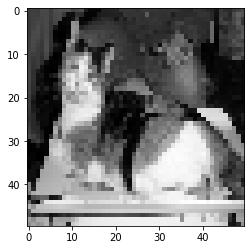

In [10]:
import matplotlib.pyplot as plt 

plt.imshow(training_data[0][0],cmap="gray")

plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [17]:

class Net(nn.Module):
    def __init__(self):
        super(). __init__() #just run the init of parent class (nn.Module)   
        self.conv1= nn.Conv2d(1,32,5) #input is 1 image, 32 output channels, 5x5 kernel(window)as it rolls over image to find features
        self.conv2= nn.Conv2d(32,64,5)
        self.conv3= nn.Conv2d(64,128,5)

        x=torch.randn(50,50).view(-1,1,50,50)
        self._to_linear=None
        self.convs(x) #passing random image to find the shape of the output of conv layers
        self.fc1=nn.Linear(self._to_linear,512)
        self.fc2=nn.Linear(512,2)
    
    def convs(self,x):    
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2)) #2x2 window
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
        

    def forward(self,x):
        x=self.convs(x)
        x=x.view(-1,self._to_linear)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.softmax(x,dim=1) #dim is the dimension to apply softmax to due to batch size
    
net=Net()

torch.Size([128, 2, 2])


In [18]:
import torch.optim as optim
optimizer=optim.Adam(net.parameters(),lr=0.001)
loss_function=nn.MSELoss()

x=torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
x=x/255.0

y=torch.Tensor([i[1] for i in training_data])

VAL_PCT=0.1 #test against 10% of our dataset
val_size=int(len(x)*VAL_PCT)
print(val_size)

2494


C:\Users\umaiskhan\AppData\Local\Temp\ipykernel_5192\2421481829.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  x=torch.Tensor([i[0] for i in training_data]).view(-1,50,50)


In [19]:
train_x=x[:-val_size]
train_y=y[:-val_size]

test_x=x[-val_size:]
test_y=y[-val_size:]
print(len(train_x))
print(len(test_x))


22452
2494


In [20]:
BATCH_SIZE=100 #adjust this according to your GPU memory
EPOCHS=1

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_x),BATCH_SIZE)):
        #print(i,i+BATCH_SIZE)
        batch_x=train_x[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y=train_y[i:i+BATCH_SIZE]

        net.zero_grad()
        outputs=net(batch_x)
        loss=loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<02:24,  1.55it/s]

torch.Size([128, 2, 2])


  1%|          | 2/225 [00:01<01:52,  1.99it/s]

torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:01<01:45,  2.10it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:46,  2.07it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:02<01:48,  2.04it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:02<01:43,  2.11it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:03<01:45,  2.07it/s]

torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:03<01:44,  2.08it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:04<01:42,  2.10it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:04<01:43,  2.07it/s]

torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:05<01:43,  2.06it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:05<01:42,  2.07it/s]

torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:06<01:40,  2.11it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:06<01:38,  2.15it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:07<01:37,  2.15it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:07<01:35,  2.19it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:08<01:32,  2.26it/s]

torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:08<01:36,  2.14it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:09<01:35,  2.16it/s]

torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:09<01:30,  2.25it/s]

torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:09<01:29,  2.28it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:10<01:30,  2.24it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:10<01:33,  2.17it/s]

torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:11<01:32,  2.18it/s]

torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:11<01:28,  2.25it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:12<01:26,  2.30it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:12<01:24,  2.34it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:12<01:25,  2.29it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:13<01:23,  2.33it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:13<01:32,  2.11it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:14<01:31,  2.11it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:14<01:28,  2.17it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:15<01:29,  2.15it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:15<01:29,  2.13it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:16<01:29,  2.13it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:16<01:27,  2.16it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:17<01:31,  2.06it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:17<01:28,  2.11it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:18<01:25,  2.18it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:18<01:24,  2.19it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:19<01:24,  2.19it/s]

torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:19<01:21,  2.25it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:19<01:19,  2.28it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:20<01:25,  2.11it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:20<01:25,  2.11it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:21<01:22,  2.16it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:21<01:21,  2.19it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:22<01:18,  2.25it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:22<01:19,  2.21it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:23<01:19,  2.21it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:23<01:22,  2.10it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:24<01:21,  2.11it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:24<01:21,  2.10it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:25<01:18,  2.17it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:25<01:29,  1.89it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:26<01:29,  1.89it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:26<01:25,  1.96it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:27<01:23,  2.00it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:27<01:20,  2.06it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:28<01:28,  1.86it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:29<01:36,  1.69it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:29<01:41,  1.60it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:30<01:42,  1.59it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:30<01:31,  1.76it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:31<01:30,  1.76it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:31<01:28,  1.80it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:32<01:37,  1.62it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:33<01:39,  1.57it/s]

torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:33<01:34,  1.65it/s]

torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:34<01:33,  1.66it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:35<01:33,  1.65it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:36<01:54,  1.33it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:36<01:42,  1.49it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:37<01:31,  1.64it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:37<01:23,  1.79it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:38<01:19,  1.88it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:38<01:22,  1.79it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:39<01:15,  1.94it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:39<01:13,  1.99it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:40<01:13,  1.97it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:40<01:10,  2.04it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:40<01:08,  2.08it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:41<01:27,  1.62it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:42<01:20,  1.75it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:42<01:14,  1.88it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:43<01:10,  1.98it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:43<01:10,  1.97it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:44<01:07,  2.04it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:44<01:05,  2.08it/s]

torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:45<01:12,  1.87it/s]

torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:45<01:09,  1.92it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:46<01:06,  1.99it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:46<01:11,  1.86it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:47<01:07,  1.94it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:47<01:11,  1.81it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:48<01:12,  1.79it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:49<01:07,  1.89it/s]

torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:49<01:07,  1.89it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:50<01:04,  1.96it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:50<01:01,  2.03it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:50<01:01,  2.03it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:51<01:00,  2.02it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:51<00:59,  2.05it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:52<00:57,  2.11it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:52<01:00,  1.99it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:53<00:58,  2.05it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:53<00:56,  2.10it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:54<00:55,  2.12it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:54<00:53,  2.17it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:55<00:54,  2.10it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:55<00:55,  2.06it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:56<00:53,  2.11it/s]

torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:56<00:52,  2.15it/s]

torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:57<00:50,  2.19it/s]

torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:57<00:48,  2.25it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:58<00:51,  2.12it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:58<00:50,  2.14it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:58<00:49,  2.15it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:59<00:48,  2.16it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:59<00:48,  2.15it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [01:00<00:48,  2.15it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [01:01<00:56,  1.84it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [01:01<00:56,  1.80it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [01:02<00:54,  1.84it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [01:02<00:52,  1.92it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [01:03<00:48,  2.03it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [01:03<00:46,  2.10it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [01:04<00:48,  2.00it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [01:04<00:47,  2.03it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [01:05<00:45,  2.08it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [01:05<00:44,  2.13it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [01:05<00:43,  2.14it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [01:06<00:46,  1.99it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [01:06<00:43,  2.08it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [01:07<00:42,  2.10it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [01:07<00:43,  2.07it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [01:08<00:41,  2.12it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [01:08<00:40,  2.14it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [01:09<00:42,  2.03it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [01:09<00:41,  2.07it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [01:10<00:40,  2.07it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [01:10<00:39,  2.10it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [01:11<00:38,  2.12it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [01:11<00:40,  2.00it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [01:12<00:38,  2.06it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [01:12<00:37,  2.13it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [01:13<00:37,  2.09it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [01:13<00:36,  2.09it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [01:14<00:38,  1.99it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [01:14<00:37,  2.01it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [01:15<00:36,  2.04it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [01:15<00:35,  2.06it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [01:16<00:34,  2.10it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [01:16<00:33,  2.14it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [01:17<00:34,  2.01it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [01:17<00:33,  2.04it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [01:18<00:32,  2.10it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [01:18<00:32,  2.07it/s]

torch.Size([128, 2, 2])


 71%|███████   | 159/225 [01:18<00:31,  2.10it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [01:19<00:32,  2.01it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [01:20<00:31,  2.03it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [01:20<00:30,  2.09it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [01:20<00:30,  2.03it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [01:21<00:30,  2.03it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [01:22<00:31,  1.93it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [01:22<00:29,  1.99it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [01:23<00:28,  2.00it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [01:23<00:28,  2.00it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [01:23<00:27,  2.05it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [01:24<00:27,  1.98it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [01:25<00:27,  1.97it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [01:25<00:27,  1.94it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [01:26<00:26,  1.95it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [01:26<00:25,  1.98it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [01:27<00:26,  1.86it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [01:30<01:07,  1.38s/it]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [01:36<02:06,  2.63s/it]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [01:44<03:20,  4.26s/it]

torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [01:48<03:16,  4.27s/it]

torch.Size([128, 2, 2])


 80%|████████  | 180/225 [01:49<02:28,  3.31s/it]

torch.Size([128, 2, 2])


 80%|████████  | 181/225 [01:50<01:55,  2.62s/it]

torch.Size([128, 2, 2])


 81%|████████  | 182/225 [01:52<01:40,  2.34s/it]

torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [01:53<01:29,  2.14s/it]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [01:54<01:14,  1.83s/it]

torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [01:56<01:08,  1.72s/it]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [01:57<00:57,  1.48s/it]

torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [01:58<00:47,  1.26s/it]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [01:58<00:39,  1.07s/it]

torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:59<00:34,  1.04it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [02:00<00:31,  1.10it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [02:00<00:27,  1.22it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [02:01<00:24,  1.33it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [02:02<00:22,  1.40it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [02:02<00:20,  1.48it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [02:03<00:21,  1.41it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [02:04<00:20,  1.42it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [02:04<00:20,  1.36it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [02:05<00:19,  1.36it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [02:06<00:18,  1.37it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [02:07<00:19,  1.30it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [02:07<00:17,  1.34it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [02:08<00:17,  1.30it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [02:09<00:16,  1.31it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [02:10<00:16,  1.28it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [02:11<00:15,  1.32it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [02:11<00:13,  1.37it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [02:12<00:12,  1.43it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [02:12<00:11,  1.48it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [02:13<00:11,  1.45it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [02:14<00:10,  1.44it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [02:15<00:09,  1.48it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [02:15<00:08,  1.50it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [02:16<00:08,  1.45it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [02:17<00:07,  1.50it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [02:17<00:06,  1.61it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [02:18<00:05,  1.70it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [02:18<00:04,  1.74it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [02:19<00:04,  1.72it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [02:19<00:03,  1.80it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [02:20<00:02,  1.87it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [02:20<00:02,  1.89it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [02:21<00:01,  1.91it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [02:21<00:01,  1.81it/s]

torch.Size([128, 2, 2])


100%|██████████| 225/225 [02:22<00:00,  1.58it/s]

torch.Size([128, 2, 2])
Epoch: 0. Loss: 0.2202402651309967


In [21]:
correct=0
total=0
with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class=torch.argmax(test_y[i])
        net_out=net(test_x[i].view(-1,1,50,50))[0]
        predicted_class=torch.argmax(net_out)
        if predicted_class==real_class:
            correct+=1
        total+=1

print("Accuracy: ", round(correct/total,3))

  1%|          | 19/2494 [00:00<00:13, 189.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  3%|▎         | 76/2494 [00:00<00:09, 260.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  7%|▋         | 179/2494 [00:00<00:07, 320.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  9%|▊         | 215/2494 [00:00<00:06, 331.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 11%|█▏        | 282/2494 [00:00<00:06, 317.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 13%|█▎        | 322/2494 [00:01<00:06, 338.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 357/2494 [00:01<00:10, 212.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 17%|█▋        | 413/2494 [00:01<00:08, 236.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 19%|█▉        | 470/2494 [00:01<00:08, 239.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 22%|██▏       | 539/2494 [00:02<00:06, 285.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 24%|██▍       | 609/2494 [00:02<00:06, 313.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 26%|██▌       | 643/2494 [00:02<00:05, 319.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 741/2494 [00:02<00:06, 279.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 31%|███       | 772/2494 [00:02<00:06, 286.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 33%|███▎      | 833/2494 [00:03<00:06, 270.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 36%|███▌      | 889/2494 [00:03<00:06, 262.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 38%|███▊      | 959/2494 [00:03<00:05, 296.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 40%|████      | 999/2494 [00:03<00:04, 325.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 1062/2494 [00:03<00:05, 243.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 45%|████▍     | 1122/2494 [00:04<00:05, 259.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 47%|████▋     | 1181/2494 [00:04<00:04, 272.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 50%|████▉     | 1239/2494 [00:04<00:04, 270.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 52%|█████▏    | 1304/2494 [00:04<00:04, 291.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 53%|█████▎    | 1334/2494 [00:05<00:05, 218.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 1388/2494 [00:05<00:04, 229.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 58%|█████▊    | 1455/2494 [00:05<00:03, 272.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 61%|██████▏   | 1529/2494 [00:05<00:03, 317.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 64%|██████▍   | 1598/2494 [00:05<00:02, 307.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 67%|██████▋   | 1668/2494 [00:06<00:02, 321.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 70%|██████▉   | 1735/2494 [00:06<00:03, 225.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 73%|███████▎  | 1809/2494 [00:06<00:02, 265.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 75%|███████▌  | 1875/2494 [00:06<00:02, 279.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 78%|███████▊  | 1942/2494 [00:07<00:01, 301.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 81%|████████  | 2012/2494 [00:07<00:01, 310.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 82%|████████▏ | 2044/2494 [00:07<00:01, 275.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 2073/2494 [00:07<00:02, 192.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 85%|████████▌ | 2128/2494 [00:08<00:01, 201.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 2151/2494 [00:08<00:01, 176.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 2191/2494 [00:08<00:01, 171.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 2243/2494 [00:08<00:01, 210.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 92%|█████████▏| 2300/2494 [00:08<00:00, 244.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 2326/2494 [00:09<00:00, 187.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 97%|█████████▋| 2412/2494 [00:09<00:00, 250.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 98%|█████████▊| 2445/2494 [00:09<00:00, 271.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2494/2494 [00:09<00:00, 257.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.532
